In [2]:
print("shree ram")

shree ram


In [24]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix
import seaborn as sns
import numpy as np
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix
import seaborn as sns
import numpy as np
from collections import Counter
import random
from torch.cuda.amp import autocast, GradScaler

In [26]:
# Paths
data_dir = r"C:/splitted data"
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

In [62]:
# Check directories and files
print("Verifying dataset directories...")
for d in [train_dir, val_dir, test_dir]:
    if not os.path.exists(d):
        print(f"Error: Directory {d} does not exist.")
        exit(1)
    files = []
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        files.extend(list(Path(d).rglob(ext)))
    print(f"{d}: Found {len(files)} image files (jpg, jpeg, png).")
    if not files:
        print(f"Error: No image files found in {d}. Check folder structure or file formats.")
        exit(1)

Verifying dataset directories...
C:\splitted data\train: Found 3818 image files (jpg, jpeg, png).
C:\splitted data\val: Found 1014 image files (jpg, jpeg, png).
C:\splitted data\test: Found 505 image files (jpg, jpeg, png).


In [71]:
# Check for data leakage
def check_data_leakage(train_dir, val_dir, test_dir, extensions=('*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG')):
    def get_file_hash(file_path):
        try:
            with open(file_path, 'rb') as f:
                return hashlib.md5(f.read()).hexdigest()
        except (IOError, PermissionError) as e:
            print(f"Warning: Failed to hash {file_path}: {e}")
            return None
    
    train_files = {}
    val_files = {}
    test_files = {}
    skipped_files = {'train': [], 'val': [], 'test': []}
    
    for ext in extensions:
        for f in Path(train_dir).rglob(ext):
            h = get_file_hash(f)
            if h is not None:
                train_files[h] = f
            else:
                skipped_files['train'].append(f)
        for f in Path(val_dir).rglob(ext):
            h = get_file_hash(f)
            if h is not None:
                val_files[h] = f
            else:
                skipped_files['val'].append(f)
        for f in Path(test_dir).rglob(ext):
            h = get_file_hash(f)
            if h is not None:
                test_files[h] = f
            else:
                skipped_files['test'].append(f)
    
    print(f"Files scanned: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")
    for split, skipped in skipped_files.items():
        if skipped:
            print(f"Skipped {len(skipped)} {split} files due to hashing errors:")
            for f in skipped[:5]:
                print(f"  {f}")
            if len(skipped) > 5:
                print(f"  ...and {len(skipped)-5} more")
    
    train_val_common = set(train_files.keys()) & set(val_files.keys())
    train_test_common = set(train_files.keys()) & set(test_files.keys())
    val_test_common = set(val_files.keys()) & set(test_files.keys())
    
    duplicates_found = False
    if train_val_common:
        duplicates_found = True
        print(f"Train-Val duplicates: {len(train_val_common)} files")
        for h in train_val_common:
            print(f"  Train: {train_files[h]}")
            print(f"  Val: {val_files[h]}")
    if train_test_common:
        duplicates_found = True
        print(f"Train-Test duplicates: {len(train_test_common)} files")
        for h in train_test_common:
            print(f"  Train: {train_files[h]}")
            print(f"  Test: {test_files[h]}")
    if val_test_common:
        duplicates_found = True
        print(f"Val-Test duplicates: {len(val_test_common)} files")
        for h in val_test_common:
            print(f"  Val: {val_files[h]}")
            print(f"  Test: {test_files[h]}")
    
    if not duplicates_found:
        print("No data leakage detected.")
    return train_val_common, train_test_common, val_test_common, train_files, val_files, test_files

# Remove duplicates
def remove_duplicates(train_val_dups, train_test_dups, val_test_dups, train_files, val_files, test_files, val_dir, test_dir):
    import os
    for h in train_val_dups:
        val_path = val_files[h]
        if os.path.exists(val_path):
            print(f"Removing {val_path}")
            os.remove(val_path)
        else:
            print(f"Warning: File not found, skipping: {val_path}")
    for h in train_test_dups:
        test_path = test_files[h]
        if os.path.exists(test_path):
            print(f"Removing {test_path}")
            os.remove(test_path)
        else:
            print(f"Warning: File not found, skipping: {test_path}")
    for h in val_test_dups:
        test_path = test_files[h]
        if os.path.exists(test_path):
            print(f"Removing {test_path}")
            os.remove(test_path)
        else:
            print(f"Warning: File not found, skipping: {test_path}")
    print("Duplicates removal process completed.")

print("\nChecking for data leakage...")
train_val_dups, train_test_dups, val_test_dups, train_files, val_files, test_files = check_data_leakage(train_dir, val_dir, test_dir)
if train_val_dups or train_test_dups or val_test_dups:
    print("\nRemoving duplicates...")
    remove_duplicates(train_val_dups, train_test_dups, val_test_dups, train_files, val_files, test_files, val_dir, test_dir)
    print("\nRe-running leakage check after removal...")
    check_data_leakage(train_dir, val_dir, test_dir)
else:
    print("No duplicates to remove.")




Checking for data leakage...
Files scanned: 3678 train, 1007 val, 505 test
No data leakage detected.
No duplicates to remove.


In [63]:
# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [72]:
# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),  # Increased for better generalization
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Added to reduce overfitting
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [65]:
# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)


In [66]:
# Print dataset details
def print_dataset_details(dataset, name):
    class_names = dataset.classes
    class_counts = Counter(dataset.targets)
    total = len(dataset)
    print(f"{name}: {total} images ({', '.join(f'{class_names[i]}: {class_counts[i]}' for i in range(len(class_names)))})")
print("\nDataset Details:")
print_dataset_details(train_dataset, "Train")
print_dataset_details(val_dataset, "Val")
print_dataset_details(test_dataset, "Test")


Dataset Details:
Train: 3818 images (Animals: 1983, humans: 1835)
Val: 1014 images (Animals: 567, humans: 447)
Test: 505 images (Animals: 284, humans: 221)



Displaying 6 Sample Images from Training Set:


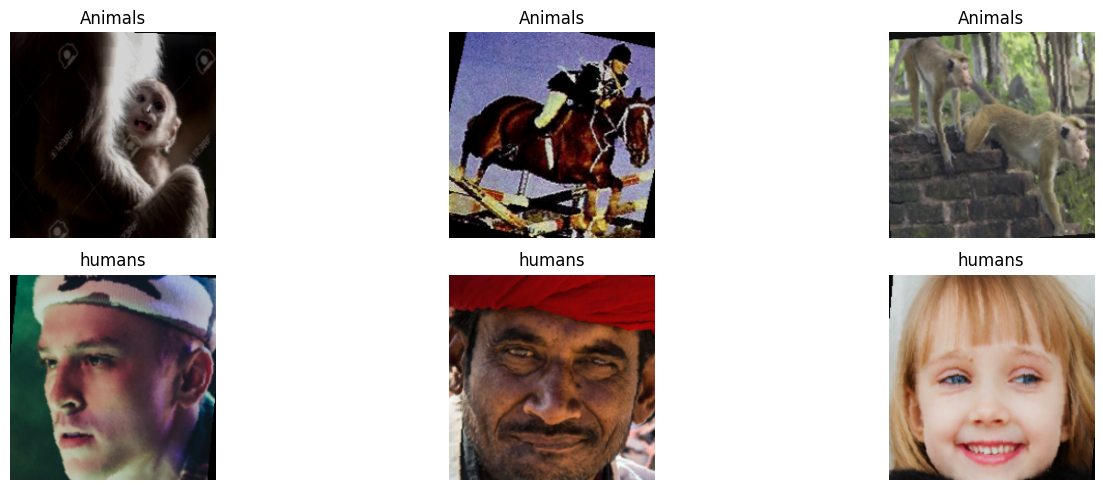

In [73]:
import random

# Display sample images
def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

print("\nDisplaying 6 Sample Images from Training Set:")
plt.figure(figsize=(15, 5))
class_names = train_dataset.classes
# Get all indices for each class
animal_indices = [i for i, (_, label) in enumerate(train_dataset.samples) if label == 0]
human_indices = [i for i, (_, label) in enumerate(train_dataset.samples) if label == 1]
# Randomly select 3 indices per class
random_animal_indices = random.sample(animal_indices, 3)
random_human_indices = random.sample(human_indices, 3)
sample_indices = random_animal_indices + random_human_indices

for i, idx in enumerate(sample_indices):
    img, label = train_dataset[idx]
    plt.subplot(2, 3, i+1)
    imshow(img, f"{class_names[label]}")
plt.tight_layout()
plt.show()

In [80]:
# Data loaders
batch_size = 16 if device.type == "cuda" else 16  # Increased for GPU
num_workers = 4 if device.type == "cuda" else 0  # Increased for GPU
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=device.type == "cuda")
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=device.type == "cuda")
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=device.type == "cuda")


In [81]:

# Model setup (DenseNet121)
model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, 2)
model = model.to(device)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [69]:

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, min_lr=1e-6, verbose=True)
scaler = GradScaler() if device.type == "cuda" else None

c:\Users\aksha\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\aksha\AppData\Local\Temp\ipykernel_7776\1703043954.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if device.type == "cuda" else None


In [77]:
# Training loop
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_acc = 0.0
best_model_state = None

for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    model.train()
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch", leave=True) as pbar:
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            if device.type == "cuda":
                with torch.cuda.amp.autocast(dtype=torch.float16):
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            pbar.update(1)
    
    train_loss = train_loss / len(train_loader)
    train_acc = train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc * 100)
    
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            if device.type == "cuda":
                with torch.cuda.amp.autocast(dtype=torch.float16):
                    outputs = model(images)
                    loss = criterion(outputs, labels)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc * 100)
    
    scheduler.step(val_loss)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        print(f"Best validation accuracy updated: {val_acc:.4f}")
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc:.4f} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f}")
# Save best model
if best_model_state is not None:
    torch.save(best_model_state, 'best_densenet121.pth')
    print(f"Saved best model with validation accuracy: {best_val_acc:.4f}")



Epoch 1/10:   0%|          | 0/60 [00:00<?, ?batch/s]C:\Users\aksha\AppData\Local\Temp\ipykernel_7776\1988502285.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16):
Epoch 1/10:   0%|          | 0/60 [00:16<?, ?batch/s]


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


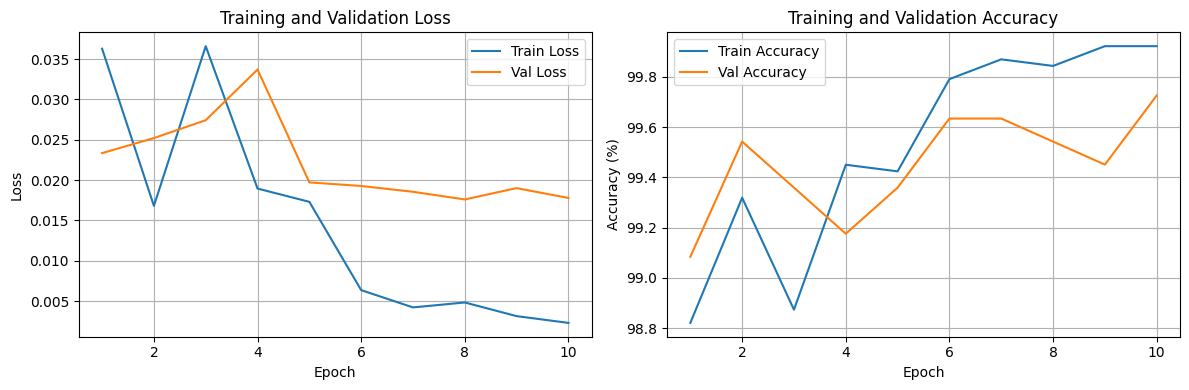

C:\Users\aksha\AppData\Local\Temp\ipykernel_7776\24457195.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=device.type == "cuda"):



Test Evaluation Metrics:
Accuracy: 0.9945
Precision: 1.0000
Recall: 0.9886
F1-Score: 0.9943
AUC: 1.0000

Confusion Matrix:
[[284   0]
 [  3 260]]


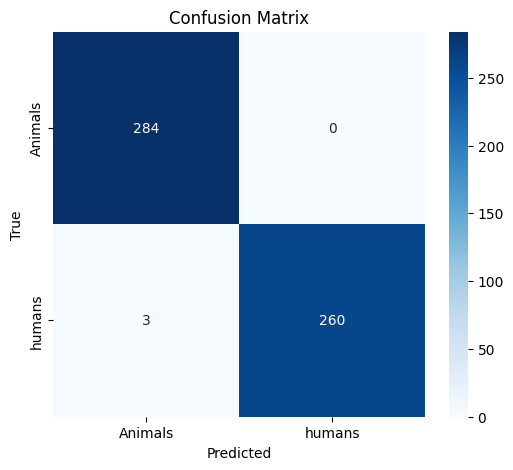

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_plots.png')
plt.show()

# Test evaluation
model.load_state_dict(torch.load('best_densenet121.pth'))
model.eval()
test_correct = 0
test_total = 0
all_labels = []
all_probs = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        if device.type == "cuda":
            with autocast(enabled=True, dtype=torch.float16):
                outputs = model(images)
                probs = torch.softmax(outputs, dim=1)[:, 1]
                _, predicted = torch.max(outputs, 1)
        else:
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

test_acc = test_correct / test_total
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
auc = roc_auc_score(all_labels, all_probs)
cm = confusion_matrix(all_labels, all_preds)

# Print evaluation metrics
print("\nTest Evaluation Metrics:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Animals', 'humans'], yticklabels=['Animals', 'humans'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

In [61]:
import hashlib
from pathlib import Path

def check_data_leakage(train_dir, val_dir, test_dir):
    def get_file_hash(file_path):
        with open(file_path, 'rb') as f:
            return hashlib.md5(f.read()).hexdigest()
    
    train_files = {get_file_hash(f): f for f in Path(train_dir).rglob('*.jpg')}
    val_files = {get_file_hash(f): f for f in Path(val_dir).rglob('*.jpg')}
    test_files = {get_file_hash(f): f for f in Path(test_dir).rglob('*.jpg')}
    
    train_val_common = set(train_files.keys()) & set(val_files.keys())
    train_test_common = set(train_files.keys()) & set(test_files.keys())
    val_test_common = set(val_files.keys()) & set(test_files.keys())
    
    if train_val_common or train_test_common or val_test_common:
        print("Warning: Data leakage detected!")
        if train_val_common:
            print(f"Train-Val duplicates: {len(train_val_common)} files")
        if train_test_common:
            print(f"Train-Test duplicates: {len(train_test_common)} files")
        if val_test_common:
            print(f"Val-Test duplicates: {len(val_test_common)} files")
    else:
        print("No data leakage detected.")

print("\nChecking for data leakage...")
check_data_leakage(train_dir, val_dir, test_dir)


Checking for data leakage...
No data leakage detected.


In [59]:
import os
import hashlib
from pathlib import Path

# Paths
data_dir = r"C:\splitted data"
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Check directories and files
print("Verifying dataset directories...")
for d in [train_dir, val_dir, test_dir]:
    if not os.path.exists(d):
        print(f"Error: Directory {d} does not exist.")
        exit(1)
    files = []
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        files.extend(list(Path(d).rglob(ext)))
    print(f"{d}: Found {len(files)} image files (jpg, jpeg, png).")
    if not files:
        print(f"Error: No image files found in {d}. Check folder structure or file formats.")
        exit(1)

# Check for data leakage
def check_data_leakage(train_dir, val_dir, test_dir, extensions=('*.jpg', '*.jpeg', '*.png')):
    def get_file_hash(file_path):
        with open(file_path, 'rb') as f:
            return hashlib.md5(f.read()).hexdigest()
    
    train_files = {}
    val_files = {}
    test_files = {}
    for ext in extensions:
        train_files.update({get_file_hash(f): f for f in Path(train_dir).rglob(ext)})
        val_files.update({get_file_hash(f): f for f in Path(val_dir).rglob(ext)})
        test_files.update({get_file_hash(f): f for f in Path(test_dir).rglob(ext)})
    
    print(f"Files scanned: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")
    
    train_val_common = set(train_files.keys()) & set(val_files.keys())
    train_test_common = set(train_files.keys()) & set(test_files.keys())
    val_test_common = set(val_files.keys()) & set(test_files.keys())
    
    duplicates_found = False
    if train_val_common:
        duplicates_found = True
        print(f"Train-Val duplicates: {len(train_val_common)} files")
        for h in train_val_common:
            print(f"  Train: {train_files[h]}")
            print(f"  Val: {val_files[h]}")
    if train_test_common:
        duplicates_found = True
        print(f"Train-Test duplicates: {len(train_test_common)} files")
        for h in train_test_common:
            print(f"  Train: {train_files[h]}")
            print(f"  Test: {test_files[h]}")
    if val_test_common:
        duplicates_found = True
        print(f"Val-Test duplicates: {len(val_test_common)} files")
        for h in val_test_common:
            print(f"  Val: {val_files[h]}")
            print(f"  Test: {test_files[h]}")
    
    if not duplicates_found:
        print("No data leakage detected.")
    return train_val_common, train_test_common, val_test_common, train_files, val_files, test_files

# Remove duplicates
def remove_duplicates(train_val_dups, train_test_dups, val_test_dups, train_files, val_files, test_files, val_dir, test_dir):
    import os
    for h in train_val_dups:
        val_path = val_files[h]
        if os.path.exists(val_path):
            print(f"Removing {val_path}")
            os.remove(val_path)
        else:
            print(f"Warning: File not found, skipping: {val_path}")
    for h in train_test_dups:
        test_path = test_files[h]
        if os.path.exists(test_path):
            print(f"Removing {test_path}")
            os.remove(test_path)
        else:
            print(f"Warning: File not found, skipping: {test_path}")
    for h in val_test_dups:
        test_path = test_files[h]
        if os.path.exists(test_path):
            print(f"Removing {test_path}")
            os.remove(test_path)
        else:
            print(f"Warning: File not found, skipping: {test_path}")
    print("Duplicates removal process completed.")

# Execute
print("\nChecking for data leakage...")
train_val_dups, train_test_dups, val_test_dups, train_files, val_files, test_files = check_data_leakage(train_dir, val_dir, test_dir)
if train_val_dups or train_test_dups or val_test_dups:
    print("\nRemoving duplicates...")
    remove_duplicates(train_val_dups, train_test_dups, val_test_dups, train_files, val_files, test_files, val_dir, test_dir)
    print("\nRe-running leakage check after removal...")
    check_data_leakage(train_dir, val_dir, test_dir)
else:
    print("No duplicates to remove.")

Verifying dataset directories...


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002CB49A11260>
Traceback (most recent call last):
  File "c:\Users\aksha\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "c:\Users\aksha\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py", line 1576, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


C:\splitted data\train: Found 3818 image files (jpg, jpeg, png).
C:\splitted data\val: Found 1014 image files (jpg, jpeg, png).
C:\splitted data\test: Found 505 image files (jpg, jpeg, png).

Checking for data leakage...
Files scanned: 3678 train, 1007 val, 505 test
No data leakage detected.
No duplicates to remove.
